In [1]:
import numpy as np
import json
import torch
import torch.nn as nn
from networks import SCLIPNN
import clip
from PIL import Image
from sentence_transformers import SentenceTransformer
import torchvision.transforms.functional as fn
import pandas as pd
import yaml

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
with open("config.yml", "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)
directory = cfg["dataset"]["dirname"]
image_directory = cfg["dataset"]["images"]
languages = cfg["languages"]

In [18]:
sbert_model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
clip_model, preprocess = clip.load("ViT-B/32", device=device)

In [19]:
def reshape(im):
    print("This is size of original image:",im.size, "\n")
    width, height = im.size
    # print("W: {} and H: {}".format(width, height))
    if width > 1000 or height > 1000:
        scale = 3
    elif width > 500 or height > 500:
        scale = 2
    else:
        scale = 1    
    new_width = int(width / scale)
    new_height = int(height / scale)
    #image = preprocess(im)
    image = fn.resize(im, size=[new_width])
    print("This is size of resized image:",image.size, "\n")
    return image

In [20]:
def get_logits(image_features, text_features):
    # normalized features
    if text_features.dtype == torch.int64:
        text_features = text_features.type(torch.FloatTensor)
    image_features = (image_features / image_features.norm(dim=-1, keepdim=True)).to(device)
    text_features = (text_features / text_features.norm(dim=-1, keepdim=True)).to(device)

    # cosine similarity as logits
    logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))
    logit_scale = logit_scale.exp().to(device)
    logits_per_image = logit_scale * image_features @ text_features.t()
    logits_per_text = logits_per_image.t()

    # shape = [global_batch_size, global_batch_size]
    return logits_per_image, logits_per_text  

In [21]:
def sbert_to_clip(sbert_features):
    input_size = sbert_features.shape[1]
    PATH = "models/best_model.pt"
    model = SCLIPNN(input_size,850)
    model.load_state_dict(torch.load(PATH))
    model.eval()
    output = model(sbert_features)
    return output

In [22]:
def get_image(directory, image_id):
    image = Image.open(directory + image_id)
    return image

In [23]:
def reciprocal_rank(probs, value):
    N = len(probs)
    copy_probs = list(probs.copy())
    for i in range(N):
        max_value = max(copy_probs)
        if max_value == value:
            return 1/(i + 1)
        else:
            copy_probs.remove(max_value)
    return 1/N

In [24]:
sbert_lang_performance = []
clip_lang_performance = []
sbert_lang_errors = []
clip_lang_errors = []
sbert_lang_mrr = []
clip_lang_mrr = []
vetoed = []
for lang, code in languages.items():
    print("Processing captions in "+ lang +"...")
    f_json =  open(directory + code + "_pairs.json",mode='r',encoding='utf-8')
    pairs_data = json.load(f_json)
    images = []
    captions = []
    for pair in pairs_data:
        images.append(pair["image_id"])
        captions.append(pair["caption"])
        
    with torch.no_grad():
        try:
            torch_features = torch.from_numpy(sbert_model.encode(captions))
            sbert_features = sbert_to_clip(torch_features).type(torch.float16)
            tokenized_features = clip.tokenize(captions).to(device)
            clip_features = clip_model.encode_text(tokenized_features)
        except:
            print("Not able to tokenize in {}. Skipping language {}".format(lang, code))
            vetoed.append(lang)
            continue
                    
        sbert_performance = []
        clip_performance = []
        sbert_errors = 0
        clip_errors = 0
        sbert_rr = 0
        clip_rr = 0
        counter = 0
        
        for image_id in images:
            # Get the encoding of the image
            im = get_image(image_directory, image_id)
            image = preprocess(im).unsqueeze(0).to(device)
            image_features = clip_model.encode_image(image)
            
            # Get the probabilities for SBERT and CLIP
            logits_image_sbert, logits_text_sbert = get_logits(image_features, sbert_features)
            logits_image_clip, logits_text_clip = get_logits(image_features, clip_features)
            probs_clip = logits_image_clip.softmax(dim=-1).cpu().numpy()
            probs_sbert = logits_image_sbert.softmax(dim=-1).cpu().numpy()
            
            # Append the probs to array            
            ps = probs_sbert[0][counter]
            sbert_rr += reciprocal_rank(probs_sbert[0],ps)
            sbert_performance.append(ps)
            if ps < max(probs_sbert[0]):
                sbert_errors += 1
            pc = probs_clip[0][counter]
            clip_rr += reciprocal_rank(probs_clip[0],pc)
            clip_performance.append(pc)
            if pc < max(probs_clip[0]):
                clip_errors += 1
            counter += 1
       
    # print("Images processed: {}".format(counter))
    # print("Classifications errors: SBERT --> {} ; CLIP --> {}".format(sbert_errors,clip_errors))
    sbert_lang_performance.append(round(sum(sbert_performance)/counter,4))
    clip_lang_performance.append(round(sum(clip_performance)/counter,4))
    sbert_lang_mrr.append(round(sbert_rr/counter,3))
    clip_lang_mrr.append(round(clip_rr/counter,3))
    sbert_lang_errors.append(sbert_errors)
    clip_lang_errors.append(clip_errors)
print("Done")
print("Forbidden Languages: {}".format(vetoed))

Processing captions in English...
Processing captions in Spanish...
Processing captions in German...
Processing captions in French...
Processing captions in Latin...
Processing captions in Esperanto...
Processing captions in Polish...
Processing captions in Basque...
Processing captions in Portuguese...
Processing captions in Catalan...
Processing captions in Croatian...
Processing captions in Czech...
Processing captions in Danish...
Processing captions in Dutch...
Processing captions in Estonian...
Processing captions in Finnish...
Processing captions in Hungarian...
Processing captions in Icelandic...
Processing captions in Indonesian...
Processing captions in Italian...
Processing captions in Latvian...
Processing captions in Lithuanian...
Processing captions in Malay...
Processing captions in Romanian...
Processing captions in Slovak...
Processing captions in Slovenian...
Processing captions in Swahili...
Processing captions in Swedish...
Processing captions in Tamil...
Not able t

In [28]:
r = dict(languages)
for k in vetoed:
    if k in r:
        del r[k]
languages = r

In [29]:
print("Languages: {}".format(languages))
print("SBERT performance: {}".format(sbert_lang_performance))
print("CLIP performance: {}".format(clip_lang_performance))

Languages: {'English': 'en', 'Spanish': 'es', 'German': 'de', 'French': 'fr', 'Latin': 'la', 'Esperanto': 'eo', 'Polish': 'pl', 'Basque': 'eu', 'Portuguese': 'pt', 'Catalan': 'ca', 'Croatian': 'hr', 'Czech': 'cs', 'Danish': 'da', 'Dutch': 'nl', 'Estonian': 'et', 'Finnish': 'fi', 'Hungarian': 'hu', 'Icelandic': 'is', 'Indonesian': 'id', 'Italian': 'it', 'Latvian': 'lv', 'Lithuanian': 'lt', 'Malay': 'ms', 'Romanian': 'ro', 'Slovak': 'sk', 'Slovenian': 'sl', 'Swahili': 'sw', 'Swedish': 'sv', 'Turkish': 'tr', 'Welsh': 'cy'}
SBERT performance: [0.0042, 0.0077, 0.008, 0.008, 0.0035, 0.0033, 0.0072, 0.0015, 0.0038, 0.0025, 0.0017, 0.0016, 0.0019, 0.0037, 0.0013, 0.0012, 0.0013, 0.0012, 0.002, 0.0038, 0.0013, 0.0013, 0.0017, 0.0019, 0.0016, 0.0014, 0.0011, 0.0017, 0.0036, 0.0012]
CLIP performance: [0.0075, 0.0058, 0.0049, 0.0062, 0.0032, 0.0026, 0.0026, 0.0013, 0.0026, 0.0021, 0.0013, 0.0013, 0.0017, 0.0023, 0.0011, 0.0012, 0.0012, 0.0011, 0.0021, 0.0026, 0.0012, 0.0012, 0.0018, 0.0017, 0.0013

In [30]:
results = pd.DataFrame({"SBERT":sbert_lang_performance, "CLIP": clip_lang_performance,
                        "error SBERT":sbert_lang_errors, "error CLIP":clip_lang_errors,
                       "MRR sbert":sbert_lang_mrr, "MRR clip": clip_lang_mrr}, 
                       index=languages)
results

,SBERT,CLIP,error SBERT,error CLIP,MRR sbert,MRR clip
English,0.0042,0.0075,784,572,0.342,0.549
Spanish,0.0077,0.0058,370,380,0.390,0.351
German,0.0080,0.0049,369,401,0.402,0.293
French,0.0080,0.0062,367,379,0.399,0.358
Latin,0.0035,0.0032,458,456,0.145,0.144
Esperanto,0.0033,0.0026,468,486,0.129,0.080
Polish,0.0072,0.0026,380,472,0.364,0.096
Basque,0.0015,0.0013,976,966,0.067,0.066
Portuguese,0.0038,0.0026,807,851,0.309,0.247
Catalan,0.0025,0.0021,921,912,0.164,0.160


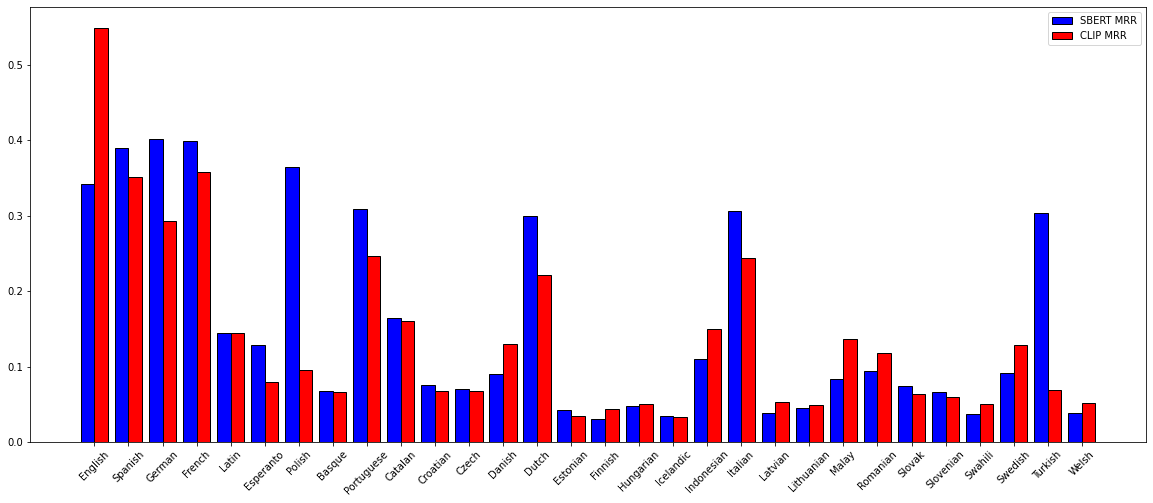

In [40]:
import matplotlib.pyplot as plt
X_axis = np.arange(len(languages.keys()))
figure_name = plt.figure(figsize=(20, 8))
plt.bar(X_axis-0.2, sbert_lang_mrr, 0.4, color = 'blue', edgecolor = 'black', capsize=7, label='SBERT MRR')
plt.bar(X_axis+0.2, clip_lang_mrr, 0.4, color = 'red', edgecolor = 'black', capsize=7, label='CLIP MRR')
plt.xticks(rotation = 45)
plt.xticks(X_axis, languages.keys())
plt.legend()
plt.show()
